In [1]:
# ! pip install SALib

     |████████████████████████████████| 756 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/Users/munraito/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import time
from math import sin, cos, tan, pi
import numba

from SALib.sample import saltelli
from SALib.analyze import sobol

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set(rc={
    'figure.figsize': (12, 8),
    'legend.fontsize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16
})

План:
1. run and get all times in classic mode
2. run with different evaluation function (numba)
3. run with different sampling function (multiproc / multithread)

In [27]:
N_SAMPLES = 2**17

problem = {
    'num_vars': 3,
    'names': ['x0' , 'x1', 'x2'],
    'bounds': [[-pi, pi], [-pi, pi], [-pi, pi]]
}

def run_SA(problem, eval_func, parallel_SA=False):
    start = time.time()
    param_values = saltelli.sample(problem, N_SAMPLES)
    sampling_time = round(time.time() - start, 2)
    print("samples generation took %s seconds" % sampling_time)

    Y = np.zeros([param_values.shape[0]])

    start = time.time()
    for i, X in enumerate(param_values):
        Y[i] = eval_func(X)
    eval_time = round(time.time() - start, 2)
    print("function evaluation took %s seconds" % eval_time)
    # plt.plot(Y[:100]);

    start = time.time()
    Si = sobol.analyze(problem, Y, parallel=parallel_SA) #, print_to_console=True
    sa_time = round(time.time() - start, 2)
    print("Sobol Analysis took %s seconds" % sa_time)
    return Si, sampling_time, eval_time, sa_time

def multivar_func_classic(x):
    return cos(x[1]) + sin(x[1]) - tan(x[0])*x[2]**3

### Classic run

samples generation took 6.56 seconds
function evaluation took 1.5 seconds
Sobol Analysis took 8.73 seconds


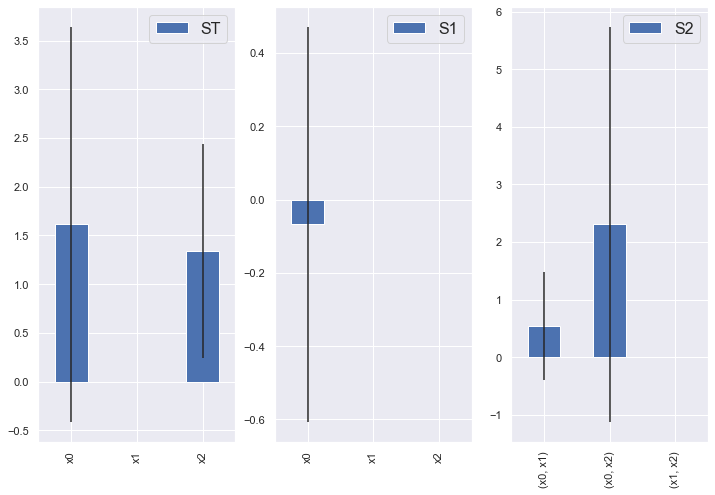

In [28]:
Si, orig_sample_time, orig_eval_time, orig_sa_time = run_SA(problem, multivar_func_classic)
Si.plot();

### Speed up eval function with numba

In [34]:
@numba.njit
def multivar_func_numba(x):
    return cos(x[1]) + sin(x[1]) - tan(x[0])*x[2]**3

In [135]:
Si, _, numba_eval_time, _ = run_SA(problem, multivar_func_numba)

samples generation took 6.46 seconds
function evaluation took 0.55 seconds
Sobol Analysis took 9.32 seconds


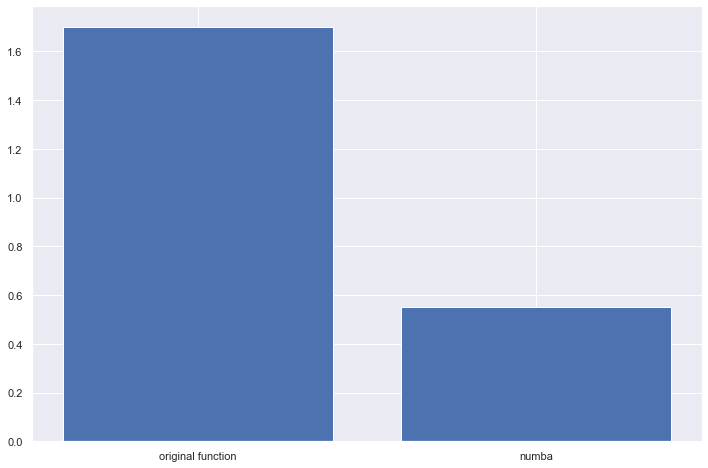

In [142]:
plt.bar(['original function', 'numba'], [orig_eval_time, numba_eval_time]);

Ускорили **Evaluation** часть почти в 4 раза

### Speed up sampling with Multiprocessing

In [1]:
import multiprocessing as mp
from workers import sample_func_classic

In [12]:
# import workers
# from importlib import reload
# workers = reload(workers)
# sample_func_classic = workers.sample_func_classic

In [15]:
def sample_func_mp(problem, n_samples):
#     num_procs = os.cpu_count()
    num_procs = 4
    print('Procs num: ', num_procs)
    n_samples_divided = n_samples // num_procs
    print(n_samples_divided)
    result = []
    with mp.Pool(num_procs) as pool:
        result = pool.map(sample_func_classic, [(problem, n_samples_divided, i+1) for i in range(num_procs)])
    return result

In [30]:
N_SAMPLES = 2**17
start = time.time()
res = sample_func_mp(problem, N_SAMPLES)
mp_time = round(time.time() - start, 2)

Procs num:  4
32768


In [29]:
np.all(res[0] == res[1]), np.all(res[1] == res[2])

(True, True)

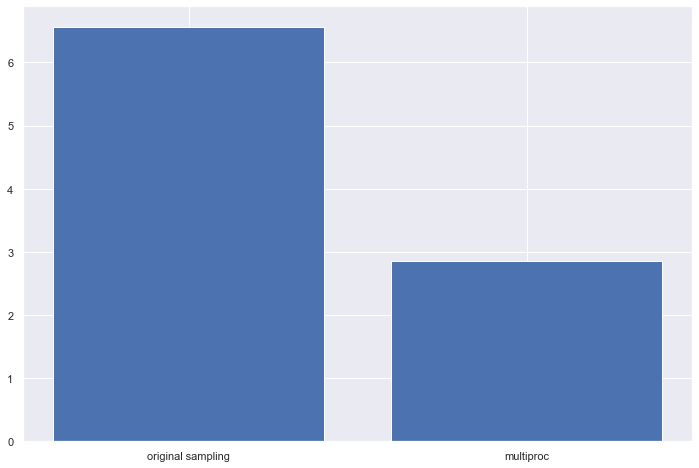

In [32]:
plt.bar(['original sampling', 'multiproc'], [orig_sample_time, mp_time]);

Время выполнения функции сэмплинга довольно заметно ускорилось, однако были сгенерированы идентичные массивы, следовательно это не принесло бы нам никакой пользы.

Т.к. в функции **saltelli.sample()** сэмплы генерируется последовательно и детерминированно, как-то распараллелить ее полезным образом не представляется возможным.

### Speed up analyze function with internal flag

In [33]:
Si, _, _, sa_parallel_time = run_SA(problem, multivar_func_numba, parallel_SA=True)

samples generation took 6.82 seconds
function evaluation took 0.57 seconds
Sobol Analysis took 8.35 seconds


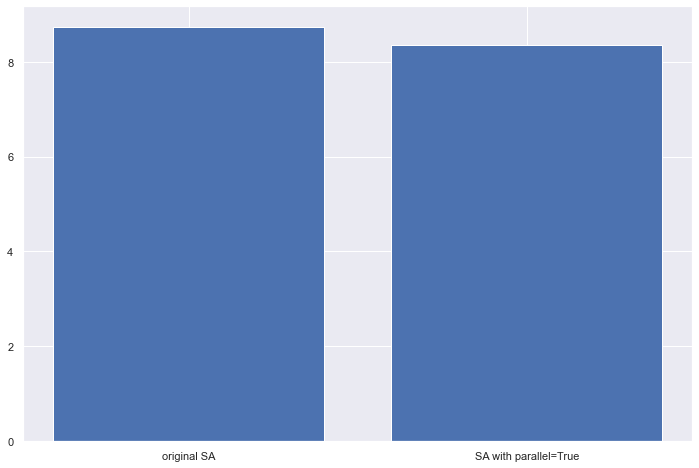

In [36]:
plt.bar(['original SA', 'SA with parallel=True'], [orig_sa_time, sa_parallel_time]);

Флаг parallel в функции **sobol.analyze()** пакета SALib не принес какого-либо значимого прироста производительности.